# Assignment 1: Graph Pathfinding with Genetic Algorithms

In [3]:
import pygad
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd

## Task 1: Shortest path between 2 nodes

Here we are creating a few graphs that will serve as examples. Graph are represented like this: first a specified number of nodes and the list of connections (*Node A*, *Node B*, *Distance*).   
The goal of the first task is to find the shortest distances between two nodes. In addition to the graph itself, the input data should also include the start and end nodes.   
Choose and implement a suitable fitness function and run a genetic algorithm to find the shortest path in a given graph provided as a .txt file.   
Experiment with different mutation/crossover functions and other GA parameters(population size, selection, etc.) and try to find the optimal configuration of the algorithm.

In [189]:
# save graph
with open("graphs/g3.txt") as f: n = int(f.readline())
print(n)

graph = pd.read_csv("graphs/g3.txt", sep=" ", skiprows=1, names=["A", "B", "w"])
print(graph)

12
     A   B  w
0    1   4  7
1    1   7  9
2    1   9  4
3    1  11  4
4    2   3  7
5    2   6  7
6    2   8  4
7    2  10  3
8    3   5  6
9    3   7  2
10   3   8  3
11   3  12  6
12   4   5  7
13   4   7  3
14   4   8  8
15   4  10  6
16   4  11  3
17   5   8  1
18   5   9  2
19   5  12  8
20   6   8  3
21   6   9  5
22   6  11  5
23   6  12  2
24   7   8  3
25   7  10  7
26   7  11  5
27   8  10  3
28   8  12  4
29   9  10  4
30   9  12  6
31  10  11  4
32  10  12  6
33  11  12  1


In [193]:
start = 5
end = 8

# gene space so nodes grafa, a brez start in end - dodala 0, za direktne povezave
gene_space = [i for i in range(0, n+1) if i != start and i != end]
print(gene_space)

[0, 1, 2, 3, 4, 6, 7, 9, 10, 11, 12]


In [194]:
INVALID = -1e12

def pathLength(pygad_instance, path, solution_index):
#def length(path):
    path_real = []
    seen = set()

    for x in path:
        if x != 0 and x not in seen:
            path_real.append(x)
            seen.add(x)
    path_real.append(end)

    N = len(path_real)
    dist = 0
    prev = start

    for i in range(N): 
        node = path_real[i]

        w = graph.loc[(graph['A'] == prev) & (graph['B'] == node), 'w']
        if w.empty:
            w = graph.loc[(graph['A'] == node) & (graph['B'] == prev), 'w'] # manjsi popravek, zaradi zapisa grafa, povezave v obe smeri
            if w.empty:
                return INVALID    # punish not available path
        
        dist += w.values[0]
        prev = node

    return -dist

#length([3])  # bi pomenilo pot 1->3->4

In [195]:
ga_instance = pygad.GA(fitness_func = pathLength,
                       num_generations=100,    #<- kasneje za probat
                       num_parents_mating=10,
                       sol_per_pop=50,
                       num_genes=(n-2), # fixed length 
                       gene_space=gene_space,
                       gene_type=int,
                      )

ga_instance.run()

In [196]:
#solution, solution_fitness, solution_idx = ga_instance.best_solution()
#print(-solution_fitness)
ga_instance.best_solution()

(array([ 9, 10,  9,  9,  0,  0, 10,  0,  9,  9]),
 np.float64(-9.0),
 np.int64(2))

## Task 2: Shortest path between multiple nodes    
The goal of the second task is to update the GA from Task 1 with the ability to follow a path consisting of multiple nodes. Your GA should receive a sequence of N target nodes A, B, C,...N and return the shortest path that follows the given node order. Paths that do not visit every target node or paths that visit the target nodes in the incorrect order are no longer valid.    
Note that your solutions may now need to visit a single node multiple times (for example, to backtrack through a graph)    
In addition, improve your GA using crossover and mutation functions. Since the task now contains strict requirements you can implement those constraints into crossover and mutation functions and into starting population.

In [184]:
# TO DO
# crossover and mutation functions

In [221]:
# target sequence
sequence = [5, 9, 10]

In [223]:
def pathLength_multipleNodes(pygad_instance, path, solution_index):
#def length(path):
    path_real = []
    seen = set()

    start = sequence[0]
    end = sequence[-1]

    for x in path:
        if x != 0 and x not in seen:
            path_real.append(x)
            seen.add(x)
    path_real.append(end)

    # check whether all of nodes in sequence are in path_real
    target_nodes_in_path = []
    for x in path_real:
        if x in sequence:
            target_nodes_in_path.append(x)

    # check if they are in correct order and if they have all the same nodes
    if sequence[1::] != target_nodes_in_path:
        return INVALID

    N = len(path_real)
    dist = 0
    prev = start

    for i in range(N): 
        node = path_real[i]

        w = graph.loc[(graph['A'] == prev) & (graph['B'] == node), 'w']
        if w.empty:
            w = graph.loc[(graph['A'] == node) & (graph['B'] == prev), 'w'] # manjsi popravek, zaradi zapisa grafa, povezave v obe smeri
            if w.empty:
                return INVALID    # punish not available path
        
        dist += w.values[0]
        prev = node

    return -dist


In [231]:
# intial population with constraints
def creating_init_pop():
    pop = []

    for _ in range(50):   # v oklepaju solutions per population
        # curr_sequence = sequence[1, -1].copy()

        # all the nodes we can add
        full_gene_space = [node for node in range(0, n+1)]

        number_of_nodes_to_insert = n-len(sequence)      # je odvisno od num_genes

        # we decide on which indices we will insert random nodes into original sequence
        # we cannot insert them in [0] and [n-1] position (start and end)

        # list of indices on which we are going to insert new nodes
        positions = []

        # list of indices we can choose from
        possible_indices = list(range(1, n-2))

        for _ in range(number_of_nodes_to_insert):
            # random choice of possible indices
            idx = np.random.choice(possible_indices)
            # we remove it from options
            possible_indices.remove(idx)
            # add to positions
            positions.append(idx)
        
        # all thats left is to build our startion population 
        # in indices from position we put a random node from full gene space

        # building process :)
        pop_individual = [-1] * n   # list of n elements with value -1

        for x in positions:
            pop_individual[x] = np.random.choice(full_gene_space)
        
        it = 0
        for i in range(n):
            if pop_individual[i] == -1:
                pop_individual[i] = sequence[it]
                it += 1

        # moja logika pravi, da bi moglu bit ok
        pop.append(pop_individual)
    
    return pop

init_pop = creating_init_pop()


In [234]:
ga_instance = pygad.GA(fitness_func = pathLength_multipleNodes,
                       num_generations=200,
                       num_parents_mating=10,
                       initial_population=init_pop,
                       sol_per_pop=50,
                       num_genes=(n), # tried with n
                       gene_space=gene_space,
                       gene_type=int,
                      )

ga_instance.run()

In [235]:
ga_instance.best_solution()

(array([ 9,  0, 12, 12,  0, 11,  0,  9, 11, 11, 11,  0]),
 np.float64(-13.0),
 np.int64(1))

c:\Users\tases\miniconda3\envs\intelsys\Lib\site-packages\pygad\visualize\plot.py:120: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  matplt.legend()


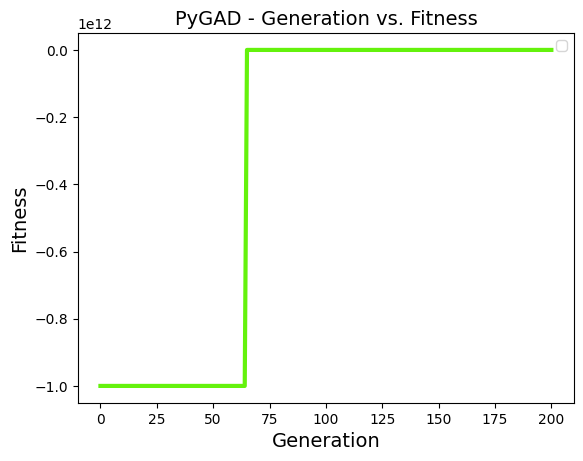

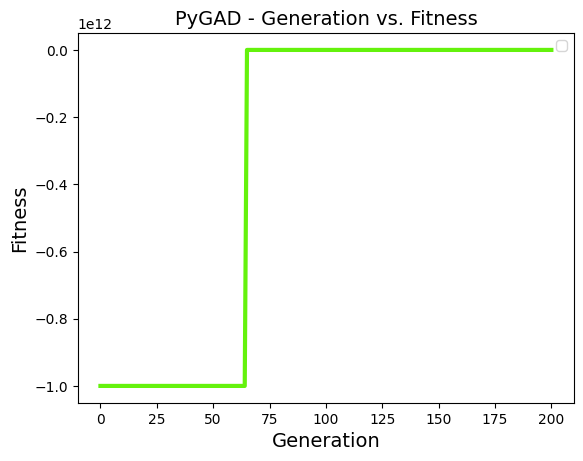

In [236]:
ga_instance.plot_fitness()